# Batch Normalization实验测试

In [40]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/", one_hot=True)

Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/Nelson/Desktop/Computer/zhihu/denoise_auto_encoder/MNIST_data/t10k-labels-idx1-ubyte.gz


# 定义类

In [1]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm=True):
        """
        initial_weights: 定义网络初始化的权重
        activation_fn: 激活函数，所有隐层采用同样的activation_fn
        use_batch_norm: 是否使用Batch Normalization
        """
        self.use_batch_norm = use_batch_norm
        self.state = "with BN" if self.use_batch_norm else "without BN"
        
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        # 网络训练结果准确率记录
        self.accuracies = []
        
        # 构建网络
        self.build_network(initial_weights, activation_fn)
        
    def build_network(self, initial_weights, activation_fn):
        """
        构建网络
        """
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)
        self.layer_output = self.fully_connected(layer_in, initial_weights[-1])
    
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):
        """
        定义全连接层
        """
        if self.use_batch_norm and activation_fn: # 使用BN的隐层
            weights = tf.Variable(initial_weights)
            logits = tf.matmul(layer_in, weights)
            batch_normalized_output = tf.layers.batch_normalization(logits, training=self.is_training)
            
            return activation_fn(batch_normalized_output)
        
        else:
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            logits = tf.add(tf.matmul(layer_in, weights), biases)
            return logits if not activation_fn else activation_fn(logits)
    
    def train_model(self, sess, learning_rate, training_batches, batches_per_sample):
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # loss & optimizer
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.layer_output))
        
        correct_preds = tf.equal(tf.argmax(self.layer_output, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
        
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
            
        
        for i in tqdm.tqdm_notebook(range(training_batches)):
            batch_xs, batch_ys = mnist.train.next_batch(60)
            sess.run(train_step, feed_dict={self.input_layer: batch_xs,
                                            labels: batch_ys,
                                            self.is_training: True})
            if i % batches_per_sample == 0:
                test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                            labels: mnist.validation.labels,
                                                            self.is_training: False})
                self.accuracies.append(test_accuracy)
        # The last accuracy
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                      labels: mnist.validation.labels,
                                                      self.is_training: False})
        
        print("{}: Final accuracy on validation set = {}".format(self.state, test_accuracy))
        
    def test_model(self, sess, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
        """
        测试集测试结果
        """
        labels = tf.placeholder(tf.float32, [None, 10])
        
        correct_preds = tf.equal(tf.argmax(self.layer_output, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
        
        if restore_from:
            tf.train.Saver().restore(sess, restore_from)
        
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                      labels: mnist.test.labels,
                                                      self.is_training: test_training_accuracy})
        
        print('{}: Accuracy on full test set = {}'.format(self.state, test_accuracy))
        
        # 小批量测试
        if include_individual_predictions:
            predictions = []
            correct = 0
            
            for i in range(200):
                pred, corr = sess.run([tf.argmax(self.layer_output,1), accuracy],
                                      feed_dict={self.input_layer: [mnist.test.images[i]],
                                                 labels: [mnist.test.labels[i]],
                                                 self.is_training: test_training_accuracy})
                
                correct += corr
                
                predictions.append(pred[0])
            
            print("200 Predictions: ", predictions)
            print("Accuracy on 200 samples: ", correct/200)
                

# 绘图函数
对训练阶段的validation的准确率进行记录并绘制趋势图

In [60]:
def plot_accuracies(*args, **kwargs):
    
    fig, ax = plt.subplots()
    
    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0, len(nn.accuracies)*batches_per_sample, batches_per_sample),
                nn.accuracies, label=nn.state)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

In [64]:
def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):
    if use_bad_weights:
        weights=[np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
                 np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                 np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                 np.random.normal(size=(100,10), scale=5.0).astype(np.float32)]
    else:
        weights=[np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
                 np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                 np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                 np.random.normal(size=(100,10), scale=0.05).astype(np.float32)]
    
    tf.reset_default_graph()
    
    # 不使用BN
    nn = NeuralNet(weights, activation_fn, False)
    # 使用BN
    bn = NeuralNet(weights, activation_fn, True)
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        print('Validation Result:\n')
        nn.train_model(sess, learning_rate, training_batches, batches_per_sample)
        bn.train_model(sess, learning_rate, training_batches, batches_per_sample)
        
        print('Test Result:\n')
        nn.test_model(sess)
        bn.test_model(sess)
        
    plot_accuracies(nn, bn, batches_per_sample=batches_per_sample)

# 实验部分


without BN: Final accuracy on validation set = 0.9761999845504761



with BN: Final accuracy on validation set = 0.9805999994277954
--------------------------------------------------
without BN: Accuracy on full test set = 0.9739000201225281
--------------------------------------------------
with BN: Accuracy on full test set = 0.9782000184059143


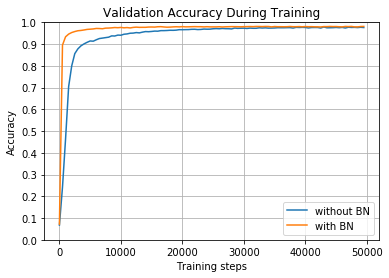

In [63]:
# 不使用bad weights，学习率为0.01，激活函数采用relu
train_and_test(False, 0.01, tf.nn.relu)

Validation Result:




without BN: Final accuracy on validation set = 0.8450000286102295



with BN: Final accuracy on validation set = 0.9549999833106995
Test Result:

without BN: Accuracy on full test set = 0.8406000137329102
with BN: Accuracy on full test set = 0.9491999745368958


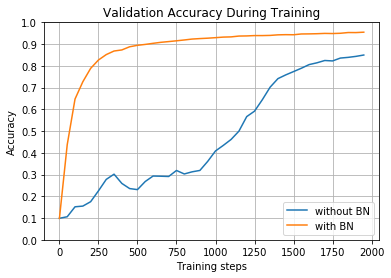

In [66]:
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

Validation Result:




without BN: Final accuracy on validation set = 0.7472000122070312



with BN: Final accuracy on validation set = 0.9764000177383423
Test Result:

without BN: Accuracy on full test set = 0.7382000088691711
with BN: Accuracy on full test set = 0.9718999862670898


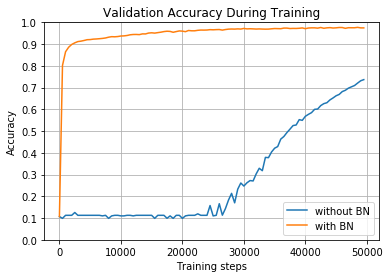

In [67]:
train_and_test(False, 0.01, tf.nn.sigmoid)

In [68]:
def leaky_relu(x, alpha=0.01):
    return tf.maximum(alpha*x, x)

Validation Result:




without BN: Final accuracy on validation set = 0.9746000170707703



with BN: Final accuracy on validation set = 0.9814000129699707
Test Result:

without BN: Accuracy on full test set = 0.9725000262260437
with BN: Accuracy on full test set = 0.9772999882698059


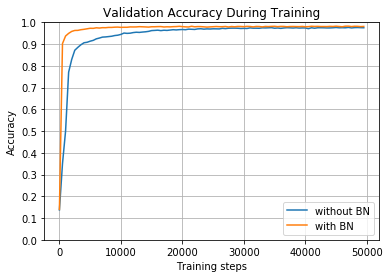

In [69]:
train_and_test(False, 0.01, leaky_relu)

Validation Result:




without BN: Final accuracy on validation set = 0.10999999940395355



with BN: Final accuracy on validation set = 0.9872000217437744
Test Result:

without BN: Accuracy on full test set = 0.10279999673366547
with BN: Accuracy on full test set = 0.9818000197410583


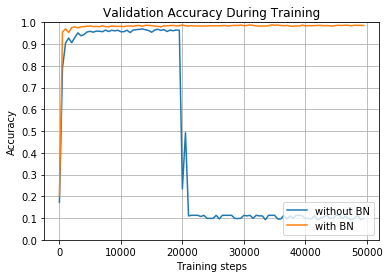

In [71]:
train_and_test(False, 1, tf.nn.relu)

Validation Result:




without BN: Final accuracy on validation set = 0.9807999730110168



with BN: Final accuracy on validation set = 0.9836000204086304
Test Result:

without BN: Accuracy on full test set = 0.9763000011444092
with BN: Accuracy on full test set = 0.9814000129699707


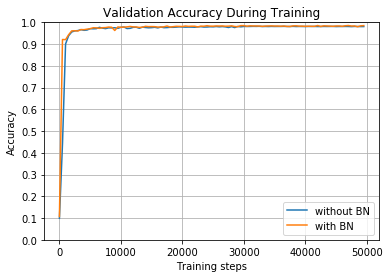

In [72]:
train_and_test(False, 2, tf.nn.sigmoid)

Validation Result:




without BN: Final accuracy on validation set = 0.9480000138282776



with BN: Final accuracy on validation set = 0.9495999813079834
Test Result:

without BN: Accuracy on full test set = 0.9402999877929688
with BN: Accuracy on full test set = 0.9437999725341797


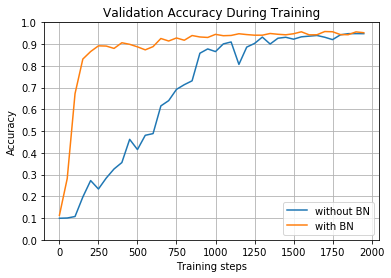

In [73]:
train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

Validation Result:




without BN: Final accuracy on validation set = 0.0957999974489212



with BN: Final accuracy on validation set = 0.8095999956130981
Test Result:

without BN: Accuracy on full test set = 0.09799999743700027
with BN: Accuracy on full test set = 0.8021000027656555


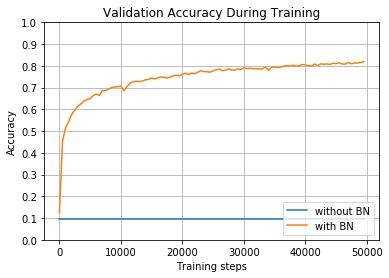

In [74]:
train_and_test(True, 0.01, tf.nn.relu)

Validation Result:




without BN: Final accuracy on validation set = 0.19099999964237213



with BN: Final accuracy on validation set = 0.8453999757766724
Test Result:

without BN: Accuracy on full test set = 0.1979999989271164
with BN: Accuracy on full test set = 0.8388000130653381


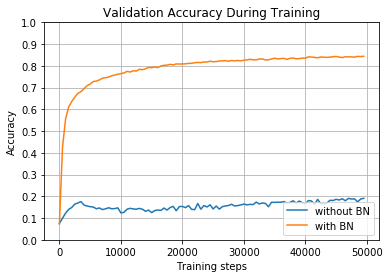

In [75]:
train_and_test(True, 0.01, tf.sigmoid)

Validation Result:




without BN: Final accuracy on validation set = 0.0957999974489212



with BN: Final accuracy on validation set = 0.526199996471405
Test Result:

without BN: Accuracy on full test set = 0.09799999743700027
with BN: Accuracy on full test set = 0.517799973487854


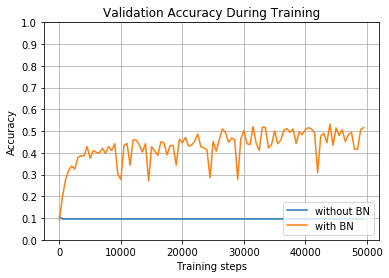

In [76]:
train_and_test(True, 1, tf.nn.relu)

Validation Result:




without BN: Final accuracy on validation set = 0.9046000242233276



with BN: Final accuracy on validation set = 0.9577999711036682
Test Result:

without BN: Accuracy on full test set = 0.9006999731063843
with BN: Accuracy on full test set = 0.948199987411499


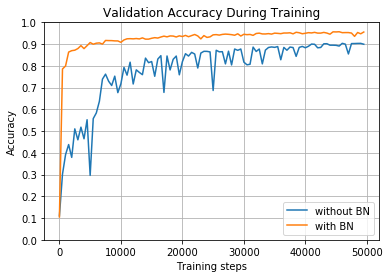

In [77]:
train_and_test(True, 1, tf.nn.sigmoid)

Validation Result:




without BN: Final accuracy on validation set = 0.0957999974489212



with BN: Final accuracy on validation set = 0.39340001344680786
Test Result:

without BN: Accuracy on full test set = 0.09799999743700027
with BN: Accuracy on full test set = 0.38089999556541443


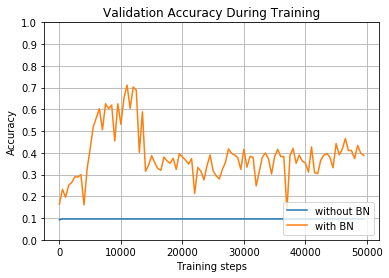

In [78]:
train_and_test(True, 2, tf.nn.relu)

# 更底层的batch normalization实现
将之前的fully connected层替换为下面的函数

In [137]:
def fully_connected(self, layer_in, initial_weights, activation_fn=None):
    if self.use_batch_norm and activation_fn:
        weights = tf.Variable(initial_weights)
        linear_output = tf.matmul(layer_in, weights)
        
        output_nodes = initial_weights.shape[-1]
        
        gamma = tf.Variable(tf.ones([output_nodes]))
        beta = tf.Variable(tf.zeros([output_nodes]))
        
        pop_mean = tf.Variable(tf.zeros([output_nodes]), trainable=False)
        pop_variance = tf.Variable(tf.ones([output_nodes]), trainable=False)
        
        epsilon = 1e-3
        
        def batch_norm_training():
            # 训练阶段
            batch_mean, batch_variance = tf.nn.moments(linear_output, [0])
            
            decay = 0.99
            
            train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
            train_variance = tf.assign(pop_variance, pop_variance * decay + batch_variance * (1 - decay))
            
            with tf.control_dependencies([train_mean, train_variance]):
                return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
            
        def batch_norm_inference():
            # 测试阶段
            return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)
        
        batch_normalized_output = tf.cond(self.is_training, batch_norm_training, batch_norm_inference)
        
        return activation_fn(batch_normalized_output)
    
    else:
        weights = tf.Variable(initial_weights)
        biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
        linear_output = tf.add(tf.matmul(layer_in, weights), biases)
        return linear_output if not activation_fn else activation_fn(linear_output)
    

In [80]:
def batch_norm_test(test_training_accuracy):
    """
    :param test_training_accuracy: bool
        If True, perform inference with batch normalization using batch mean and variance;
        if False, perform inference with batch normalization using estimated population mean and variance.
    """

    weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
              ]

    tf.reset_default_graph()

    # Train the model
    bn = NeuralNet(weights, tf.nn.relu, True)
 
    # First train the network
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        bn.train_model(sess, 0.01, 2000, 2000)

        bn.test_model(sess, test_training_accuracy=test_training_accuracy, include_individual_predictions=True)

In [81]:
batch_norm_test(True)


with BN: Final accuracy on validation set = 0.9531999826431274
with BN: Accuracy on full test set = 0.9510999917984009
200 Predictions:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Accuracy on 200 samples:  0.05


In [82]:
batch_norm_test(False)


with BN: Final accuracy on validation set = 0.9577999711036682
with BN: Accuracy on full test set = 0.9550999999046326
200 Predictions:  [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 8, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 2, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 5, 1, 6, 4, 2]
Accuracy on 200 samples:  0.97
